In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import gpflow
import cartopy.crs as ccrs
from utils_OC import *
from gpflow.config import default_float
import netCDF4 as nc
import glob
from eofs.xarray import Eof

March 2024 basic GP testing, same architecture as GP0 with validation on RAMIP 0xEU SO2 

In [2]:
in_files = glob.glob('../training_data_Ann/inputs*.nc')
out_files = glob.glob('../training_data_Ann/outputs*.nc')

In [42]:
in_files

['../training_data_Ann\\inputs_0xEA_SO2_Ann.nc',
 '../training_data_Ann\\inputs_0xEU_SO2_Ann.nc',
 '../training_data_Ann\\inputs_0xNA_SO2_Ann.nc',
 '../training_data_Ann\\inputs_0xSA_SO2_Ann.nc',
 '../training_data_Ann\\inputs_10xEU_BC_Ann.nc',
 '../training_data_Ann\\inputs_10xNA_BC_Ann.nc',
 '../training_data_Ann\\inputs_10xSA_BC_Ann.nc',
 '../training_data_Ann\\inputs_10xSA_SO2_Ann.nc',
 '../training_data_Ann\\inputs_5xEA_BC_Ann.nc',
 '../training_data_Ann\\inputs_5xEA_SO2_Ann.nc',
 '../training_data_Ann\\inputs_5xNA_SO2_Ann.nc',
 '../training_data_Ann\\inputs_7xEU_SO2_Ann.nc',
 '../training_data_Ann\\inputs_global_anthro_Ann.nc',
 '../training_data_Ann\\inputs_global_BC_Ann.nc',
 '../training_data_Ann\\inputs_global_OC_Ann.nc',
 '../training_data_Ann\\inputs_global_SO2_Ann.nc',
 '../training_data_Ann\\inputs_hist-aer.nc',
 '../training_data_Ann\\inputs_ramip_af.nc',
 '../training_data_Ann\\inputs_ramip_ea.nc',
 '../training_data_Ann\\inputs_ramip_nae.nc',
 '../training_data_Ann\\in

In [31]:
#define perturbation regions as  [lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat]
pert_regions = dict([
    ('gb', [0, -90, 360, 90]),
    ('eu', [165, 37, 210, 73]),
    ('ru', [210, 45, 380, 80]),
    ('ea', [270, -10, 330, 45]),
    ('wa', [240, 0, 270, 45]),
    ('au', [285, -45, 340, -10]),
    ('na', [10, 15, 125, 75]),
    ('sa', [95, -60, 150, 15]),
    ('af', [155, -40, 240, 37])
])

def lat_weighted_mean(x):
    weights = np.cos(np.deg2rad(x.lat))
    return x.weighted(weights).mean(['lat', 'lon'])

In [4]:
def create_predictor_regions(pert_regions, data_set):
    #for given input dataset and coordingates of regions, sum emissions in those regions and return as dataframe.
    #note: emission units are Tg/yr per gridbox (so summing over lat/lon gives Tg/yr for that region) (not fluxes!)
    inputs = pd.DataFrame()
    X = data_set

    for key_region in pert_regions:
       
        #set up lat/lon slice values:
        lat_slice = slice(pert_regions[key_region][1],pert_regions[key_region][3])
        lon_slice = slice(pert_regions[key_region][0],pert_regions[key_region][2])

        #double check that lon coordinates are correct [-180,180] and if not reassign new coords and sort increasing:
        #if X.lon.max()>180:
        #    print('re-assigning lon to [-180,180]')
        #    X=X.assign_coords(lon=(((X.lon + 180) % 360) - 180)).sortby('lon')

        #Y_CH4 = X['CH4'].sel(lat=lat_slice,lon=lon_slice).sum(('lat','lon')).to_dataframe('CH4')
        #Y_CH4 = Y_CH4.add_suffix(key_region)
        #inputs = pd.concat([inputs, Y_CH4], axis=1)

        Y_SO2 = X['SO2'].sel(lat=lat_slice,lon=lon_slice).sum(('lat','lon')).to_dataframe('SO2')
        Y_SO2 = Y_SO2.add_suffix(key_region)
        inputs = pd.concat([inputs, Y_SO2], axis=1)

        Y_BC = X['BC'].sel(lat=lat_slice,lon=lon_slice).sum(('lat','lon')).to_dataframe('BC')
        Y_BC = Y_BC.add_suffix(key_region)
        inputs = pd.concat([inputs, Y_BC], axis=1)

        Y_OC = X['OC'].sel(lat=lat_slice,lon=lon_slice).sum(('lat','lon')).to_dataframe('OC')
        Y_OC = Y_OC.add_suffix(key_region)
        inputs = pd.concat([inputs, Y_OC], axis=1)

    return inputs

In [5]:
#prepare input data:
# data are annual emissions on 1.9x2.4 degree grid. For training we want a dataframe with total emissions for each region for each year and species, and then concatentate all experiments together.
# data is normalized by mean and std of each species for each experiment later.
# NaNs replaced with 0s.

def add_year(ds):
    #add year as a coordinate to the dataset if it doesn't exist (ie for equilibrium runs where year is not a coordinate)
    if 'year' in ds.coords:
        return ds
    else:
        ds = ds.assign_coords(year=9999)
        ds = ds.expand_dims('year')
        return ds

def prep_inputs(in_files):
    #loop over input files and create a dataframe of emissions for each region for each year and experiment.
    input_df = pd.DataFrame()

    data = xr.open_mfdataset(in_files, combine='nested', concat_dim='year', preprocess=add_year)

    inputs = create_predictor_regions(pert_regions, data)
    inputs0 = inputs.fillna(0)
    input_df = pd.concat([input_df, inputs0], axis=0)

    return input_df


In [6]:
#perpare output:
# data are 1.9x2.4 gridded tas difference from baseline for each experiment.
# training dataframe size is n_years x 96*144
# drop rows that contain NaNs (and drop corresponding rows in input_df)

def prep_outputs(out_files):

    output_df = pd.DataFrame()
    
    for file in out_files:
        print(file)
        data = xr.open_dataset(file)
        data = add_year(data)

        outputs = pd.DataFrame(data['tas_diff'].values.reshape(-1, 96 * 144),index=(data['year']))
        output_df = pd.concat([output_df, outputs], axis=0)

    if output_df.isnull().any(axis=1).sum()>0:
        print('NaNs found in output_df')
        #output_df = output_df.dropna()
        #input_df = input_df.dropna() #fix to drop same rows as output_df
        #print('NaNs dropped')

    return output_df

    #data = xr.open_mfdataset(out_files, combine='nested', concat_dim='year', preprocess=add_year)

    #output_df = pd.DataFrame(data['tas_diff'].values.reshape(-1, 96 * 144),index=data['year'])


    #if output_df.isnull().any(axis=1).sum()>0:
    #    print('NaNs found in output_df')
    #    #output_df = output_df.dropna()
    #    #input_df = input_df.dropna() #fix to drop same rows as output_df
    #    #print('NaNs dropped')

    #return output_df

In [8]:
in_files[0]

'../training_data_Ann\\inputs_0xEA_SO2_Ann.nc'

In [9]:
#create training and test sets:
# keep ssp_245 as test
train_in = in_files[1:24]
test_in = in_files[0]

train_out = out_files[1:24]
test_out = out_files[0]

#prepare training data:
train_input_df = prep_inputs(train_in)
train_output_df = prep_outputs(train_out)

#prepare test data:
test_input_df = prep_inputs([test_in])
test_output = xr.open_dataset(test_out)['tas_diff']

../training_data_Ann\outputs_0xEU_SO2_Ann.nc
../training_data_Ann\outputs_0xNA_SO2_Ann.nc
../training_data_Ann\outputs_0xSA_SO2_Ann.nc
../training_data_Ann\outputs_10xEU_BC_Ann.nc
../training_data_Ann\outputs_10xNA_BC_Ann.nc
../training_data_Ann\outputs_10xSA_BC_Ann.nc
../training_data_Ann\outputs_10xSA_SO2_Ann.nc
../training_data_Ann\outputs_5xEA_BC_Ann.nc
../training_data_Ann\outputs_5xEA_SO2_Ann.nc
../training_data_Ann\outputs_5xNA_SO2_Ann.nc
../training_data_Ann\outputs_7xEU_SO2_Ann.nc
../training_data_Ann\outputs_global_anthro_Ann.nc
../training_data_Ann\outputs_global_BC_Ann.nc
../training_data_Ann\outputs_global_OC_Ann.nc
../training_data_Ann\outputs_global_SO2_Ann.nc
../training_data_Ann\outputs_hist-aer.nc
../training_data_Ann\outputs_ramip_af.nc
../training_data_Ann\outputs_ramip_ea.nc
../training_data_Ann\outputs_ramip_nae.nc
../training_data_Ann\outputs_ramip_sa.nc
../training_data_Ann\outputs_ramip_t1.nc
../training_data_Ann\outputs_ssp245-aer.nc
../training_data_Ann\outpu

In [10]:
#normalize data:
train_output_mean = train_output_df.mean()
train_output_st = train_output_df.std()
train_output_norm = ((train_output_df-train_output_mean)/train_output_st)

train_input_mean = train_input_df.mean()
train_input_st = train_input_df.std()
train_input_norm = ((train_input_df-train_input_mean)/train_input_st)

In [11]:
print(np.shape(train_input_norm))
print(np.shape(train_output_norm))
print(np.shape(test_input_df))

(1832, 27)
(1832, 13824)
(150, 27)


In [12]:
#set up basic GP model:

# Make kernel
kernel_global = gpflow.kernels.Linear(active_dims=[0, 1, 2])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[3, 6, 9, 12, 15, 18, 21, 24])
kernel_BC = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[4, 7, 10, 13, 16, 19, 22, 25])
kernel_OC = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[5, 8, 11, 14, 17, 20, 23, 26])

kernel = kernel_global + kernel_BC + kernel_SO2 + kernel_OC #+ gpflow.kernels.White()

np.random.seed(5)

model = gpflow.models.GPR(data=(train_input_norm.astype(np.float64), 
                                train_output_norm.astype(np.float64)),
                        kernel=kernel)
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
            variables=model.trainable_variables,
            options=dict(disp=True, maxiter=1000))

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 33818848.65247889
        x: [-3.097e+00  4.572e-01 ... -2.344e+00  2.288e-01]
      nit: 291
      jac: [ 1.274e-01 -1.299e+00 ...  6.022e+01 -3.267e+02]
     nfev: 344
     njev: 344
 hess_inv: <29x29 LbfgsInvHessProduct with dtype=float64>

In [13]:
#test modeL:
import tensorflow as tf
#test_output = test_output.drop('member')
test_input_norm = ((test_input_df-train_input_mean)/train_input_st)

standard_posterior_mean, standard_posterior_var = model.predict_y(test_input_norm.values)
posterior_mean = (standard_posterior_mean * train_output_st) + train_output_mean
train_std = tf.expand_dims(train_output_st,axis=0)
posterior_std = np.sqrt(standard_posterior_var) * train_std

posterior_tas = np.reshape(posterior_mean, np.shape(test_output))#[years, 96, 144])
posterior_tas_std = np.reshape(posterior_std, np.shape(test_output))#[years, 96, 144])
posterior_tas_data = xr.DataArray(posterior_tas, dims=test_output.dims, coords=test_output.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=test_output.dims, coords=test_output.coords)

In [24]:
output_std = test_output.sel(year=slice(2150,2199)).std('year')
post_std = posterior_tas_std_data.sel(year=slice(2150,2199)).mean('year')

output_mean = test_output.sel(year=slice(2150,2199)).mean('year')
post_mean = posterior_tas_data.sel(year=slice(2150,2199)).mean('year')

from scipy.stats import ttest_ind_from_stats as ttest
z_em,p_em = ttest(output_mean, output_std, 50, post_mean, post_std, 50, equal_var=False, alternative='two-sided')

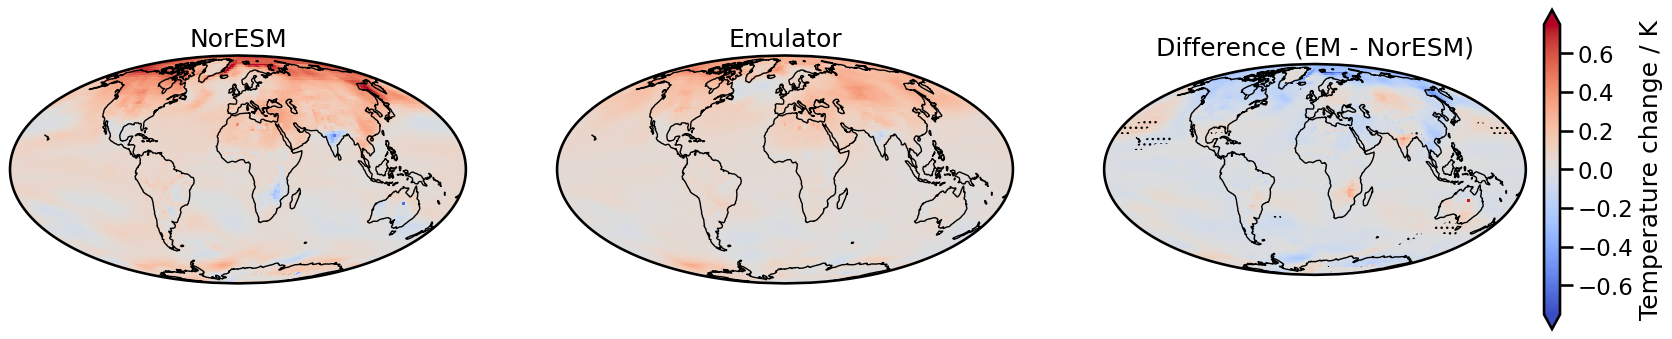

In [29]:
# plotting predictions (mean over all years)
divnorm = colors.TwoSlopeNorm(vmin=-0.75, vcenter=0., vmax=0.75)
diffnorm = colors.TwoSlopeNorm(vmin=-0.75, vcenter=0., vmax=0.75)
proj = ccrs.Mollweide()

import seaborn as sns

with sns.plotting_context("talk"):
    ## Truth
    fig = plt.figure(figsize=(20, 6))
 
    plt.subplot(131, projection=proj)
    test_output.mean('year').plot(transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm, add_colorbar=False)
    #p_mean = p_amap.mean(axis=0)
    #zm = np.ma.masked_where(p_mean<0.05, p_mean)
    #plt.pcolor(Truth.lon, Truth.lat, zm, hatch='..', alpha=0., transform=ccrs.PlateCarree())                         
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='NorESM')


    # Emulator
    plt.subplot(132, projection=proj)
    posterior_tas_data.mean('year').plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=divnorm, add_colorbar=False)
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Emulator')

    # Difference
    difference = posterior_tas_data - test_output
    plt.subplot(133, projection=proj)
    difference.mean('year').plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=diffnorm,
                    cbar_kwargs={"label":"Temperature change / K",'pad':0.04,'fraction':0.035})
    plt.contourf(difference.lon, difference.lat, p_em>0.05, colors='none', levels=[0,0.05],
                    hatches=['...'], alpha=0., transform=ccrs.PlateCarree())

    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference (EM - NorESM)')

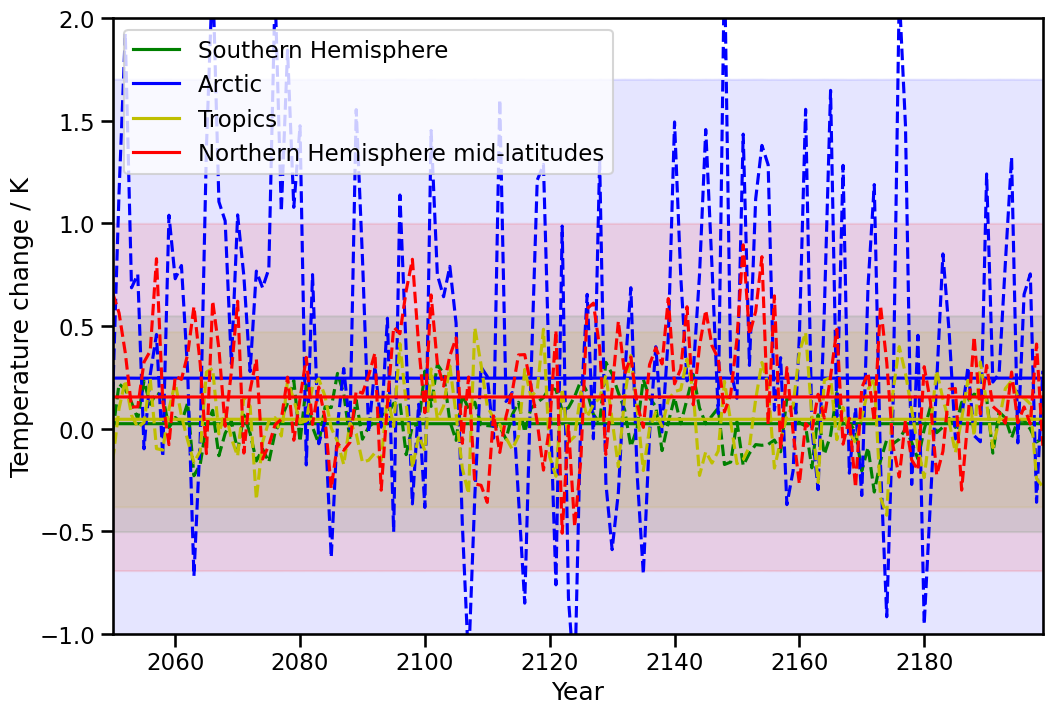

In [32]:
#trends in zonal means:
SH_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(-90,-30)))
SH_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(-90,-30)))
SH_truth = lat_weighted_mean(test_output.sel(lat=slice(-90,-30)))
Arctic_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(60,90)))
Arctic_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(60,90)))
Arctic_truth = lat_weighted_mean(test_output.sel(lat=slice(60,90)))
tropics_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(-30,30)))
tropics_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(-30,30)))
tropics_truth = lat_weighted_mean(test_output.sel(lat=slice(-30,30)))
NHml_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(30,60)))
NHml_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(30,60)))
NHml_truth = lat_weighted_mean(test_output.sel(lat=slice(30,60)))

test_var = xr.open_dataset(test_out)['diff_var']
SH_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(-90,-30))))
Arctic_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(60,90))))
tropics_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(-30,30))))
NHml_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(30,60))))

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    SH_post.plot(label='Southern Hemisphere',color='g')
    plt.fill_between(SH_post.year, SH_post-SH_post_std, SH_post+SH_post_std, color='g', alpha=0.1)
    SH_truth.plot(color='g',linestyle='--')
    Arctic_post.plot(label='Arctic',color='b')
    plt.fill_between(Arctic_post.year, Arctic_post-Arctic_post_std, Arctic_post+Arctic_post_std, color='b', alpha=0.1)
    Arctic_truth.plot(color='b',linestyle='--')
    tropics_post.plot(label='Tropics',color='y')
    plt.fill_between(tropics_post.year, tropics_post-tropics_post_std, tropics_post+tropics_post_std, color='y', alpha=0.1)
    tropics_truth.plot(color='y',linestyle='--')
    NHml_post.plot(label='Northern Hemisphere mid-latitudes',color='r')
    plt.fill_between(NHml_post.year, NHml_post-NHml_post_std, NHml_post+NHml_post_std, color='r', alpha=0.1)
    NHml_truth.plot(color='r',linestyle='--')

    plt.xlabel('Year')
    plt.ylabel('Temperature change / K')
    plt.legend(loc='upper left')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(-1., 2.)

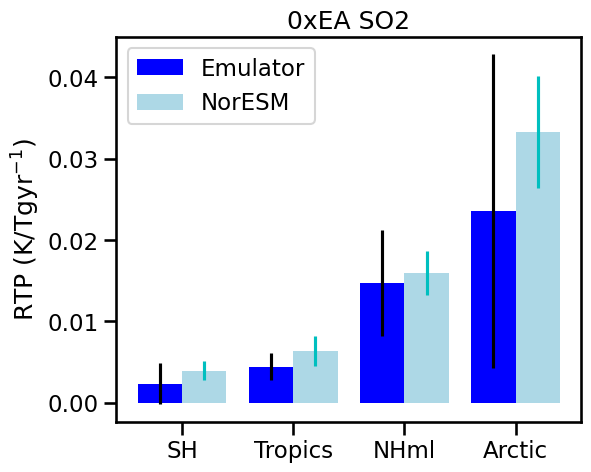

In [105]:
#bar plot ARTPS using above 4 zonal regions:
#ARTP is temperature change per Tg/yr of emissions
import scipy.stats as stats
test_inputs = xr.open_dataset(test_in)

#calculate ARTPs:
EM_arctic_SO2 = Arctic_post.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])
EM_arctic = np.abs(EM_arctic_SO2.mean('year'))
EM_SH_SO2 = SH_post.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])
EM_SH = np.abs(EM_SH_SO2.mean('year'))
EM_tropics_SO2 = tropics_post.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])
EM_tropics = np.abs(EM_tropics_SO2.mean('year'))
EM_NHml_SO2 = NHml_post.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])
EM_NHml = np.abs(EM_NHml_SO2.mean('year'))


truth_arctic_so2 = Arctic_truth.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])
truth_arctic = np.abs(truth_arctic_so2.mean('year'))
truth_SH_so2 = SH_truth.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])
truth_SH = np.abs(truth_SH_so2.mean('year'))
truth_tropics_so2 = tropics_truth.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])
truth_tropics = np.abs(truth_tropics_so2.mean('year'))
truth_NHml_so2 = NHml_truth.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])
truth_NHml = np.abs(truth_NHml_so2.mean('year'))

truth_arctic_err = stats.sem(truth_arctic_so2, axis=None, ddof=0, nan_policy='omit')
truth_SH_err = stats.sem(truth_SH_so2, axis=None, ddof=0, nan_policy='omit')
truth_tropics_err = stats.sem(truth_tropics_so2, axis=None, ddof=0, nan_policy='omit')
truth_NHml_err = stats.sem(truth_NHml_so2, axis=None, ddof=0, nan_policy='omit')

em_arctic_err = np.abs((Arctic_post_std.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])).mean('year'))**2
em_SH_err = np.abs((SH_post_std.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])).mean('year'))**2
em_tropics_err = np.abs((tropics_post_std.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])).mean('year'))**2
em_NHml_err = np.abs((NHml_post_std.sel(year=slice(2100,2199)) / test_inputs['SO2'].sel(year=slice(2100,2199)).sum(['lat','lon'])).mean('year'))**2


#plot ARTPs:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.bar([0.8,1.8,2.8,3.8], [EM_SH,EM_tropics,EM_NHml,EM_arctic], width=0.4, color='blue', label='Emulator')
    ax.errorbar([0.8,1.8,2.8,3.8], [EM_SH,EM_tropics,EM_NHml,EM_arctic], yerr=[em_SH_err,em_tropics_err,em_NHml_err,em_arctic_err], color='k', fmt='none')

    ax.bar([1.2,2.2,3.2,4.2], [truth_SH,truth_tropics,truth_NHml,truth_arctic], width=0.4, color='lightblue', label='NorESM')
    ax.errorbar([1.2,2.2,3.2,4.2], [truth_SH,truth_tropics,truth_NHml,truth_arctic], yerr=[truth_SH_err,truth_tropics_err,truth_NHml_err,truth_arctic_err], color='c', fmt='none')

    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['SH','Tropics','NHml','Arctic'])
    ax.set_ylabel('RTP (K/Tgyr$^{-1}$)')
    ax.set_title('0xEA SO2')
    ax.legend(loc='upper left')


In [96]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data


# Compute RMSEs
print(f"RMSE: {get_rmse(test_output.sel(year=slice(2100,2199)).mean('year'), posterior_tas_data.sel(year=slice(2100,2199)).mean('year'))}")


RMSE: 0.07971728125389665


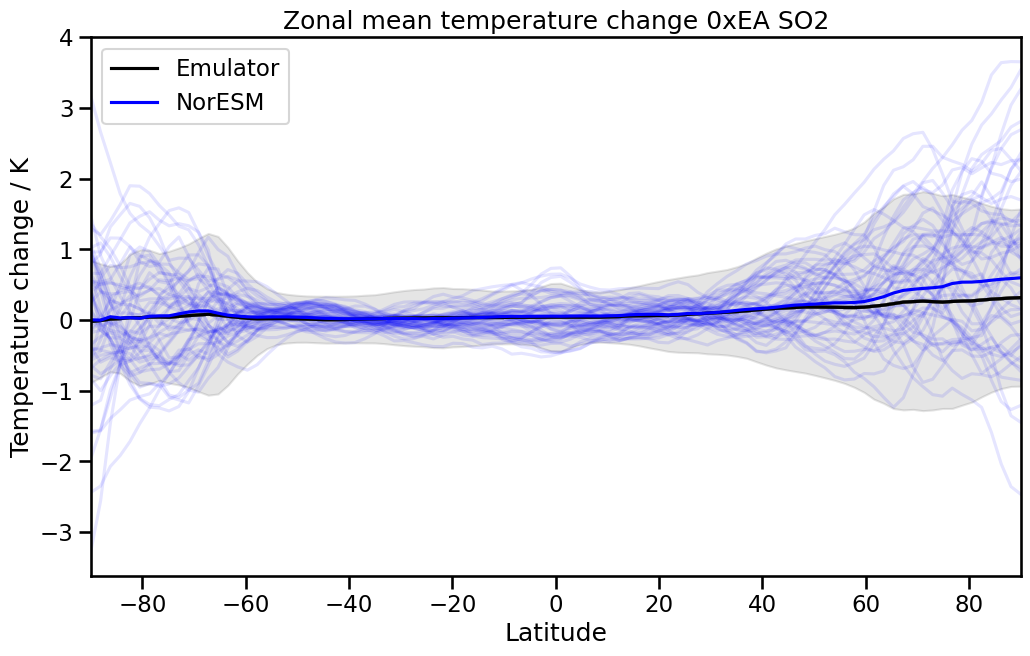

In [101]:
#zonal temperature change:
zonal_post = posterior_tas_data.mean('lon')
zonal_post_std = posterior_tas_std_data.mean('lon').mean('year')
zonal_truth = test_output.mean('lon')

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    for ii in range(50):
        plt.plot(zonal_post.lat, zonal_post[ii,:],color='grey', alpha=0.1)
        plt.plot(zonal_truth.lat, zonal_truth[ii,:], color='blue', alpha=0.1)
    plt.plot(zonal_post.lat, zonal_post.mean('year'), color='black', label='Emulator')
    plt.fill_between(zonal_post.lat, zonal_post.mean('year')-zonal_post_std, zonal_post.mean('year')+zonal_post_std, color='black', alpha=0.1)
    plt.plot(zonal_truth.lat, zonal_truth.mean('year'), color='blue', label='NorESM')
    plt.xlabel('Latitude')
    plt.ylabel('Temperature change / K')
    plt.legend()
    plt.title('Zonal mean temperature change 0xEA SO2')
    plt.autoscale(enable=True, axis='x', tight=True)